In [1]:
import os
import cv2
import time
import sys
import argparse
import tarfile
import multiprocessing
import six.moves.urllib as urllib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

In [3]:
%%bash
! echo $PYTHONPATH
! pwd

! cd ..
! pwd
! protoc object_detection/protos/*.proto --python_out=.
! export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
! 
#! export PYTHONPATH=$PYTHONPATH:$HOME/j/Lib/models:$HOME/j/Lib/models/slim
! echo $PYTHONPATH
! python object_detection/builders/model_builder_test.py


/root/models/object_detection
/root/models
:/root/models:/root/models/slim


.......
----------------------------------------------------------------------
Ran 7 tests in 0.027s

OK


In [4]:
! pwd


from utils import label_map_util

from utils import visualization_utils as vis_util

/root/models/object_detection


In [5]:
CWD_PATH = os.getcwd()
print CWD_PATH

# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
PATH_TO_CKPT = os.path.join(CWD_PATH,'data',  MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH,  'data', 'mscoco_label_map.pbtxt')


/root/models/object_detection


In [6]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [7]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
print "hi"
tar_file = tarfile.open(MODEL_FILE)
print "h"
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  print file_name
  if 'frozen_inference_graph.pb' in file_name:
    print file_name    
    tar_file.extract(file, os.getcwd())

hi
h
ssd_mobilenet_v1_coco_11_06_2017
model.ckpt.index
model.ckpt.meta
frozen_inference_graph.pb
frozen_inference_graph.pb
model.ckpt.data-00000-of-00001
graph.pbtxt


In [8]:
NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [10]:
# First test on images
! pwd

PATH_TO_TEST_IMAGES_DIR = './test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 8) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

/root/models/object_detection


In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

/root/models/object_detection
((1024, 636), (636, 1024, 3))
((300, 168), (168, 300, 3))
((328, 358), (358, 328, 3))
((279, 181), (181, 279, 3))
((275, 183), (183, 275, 3))
((278, 280), (280, 278, 3))
((366, 292), (292, 366, 3))


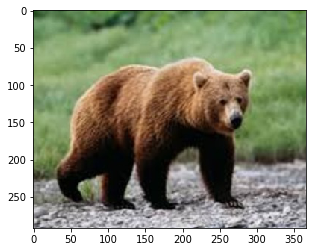

In [12]:
! pwd
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [13]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

(636, 1024, 3)
(168, 300, 3)
(358, 328, 3)
(181, 279, 3)
(183, 275, 3)
(280, 278, 3)
(292, 366, 3)


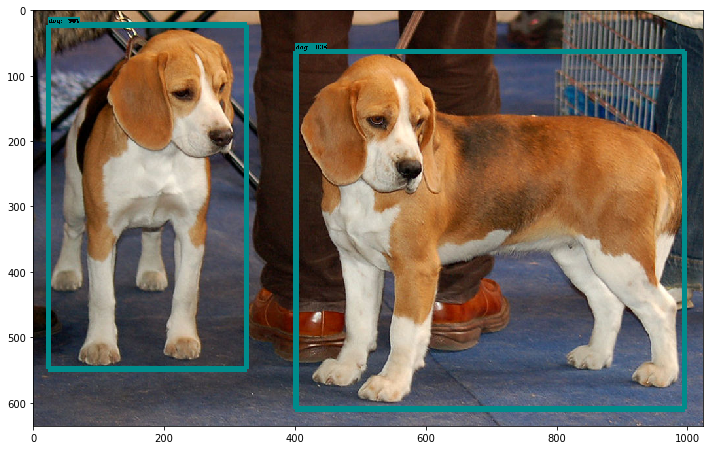

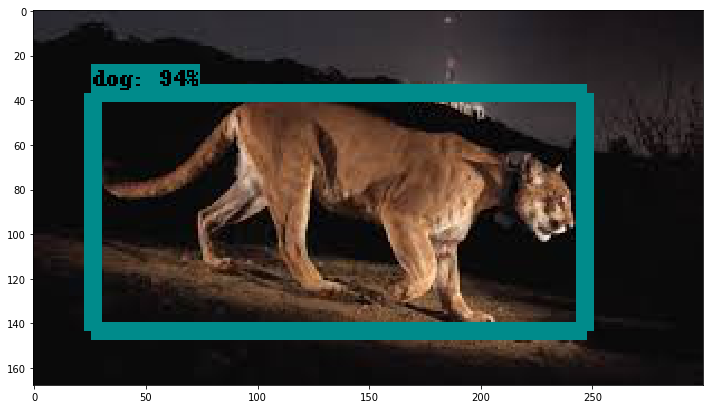

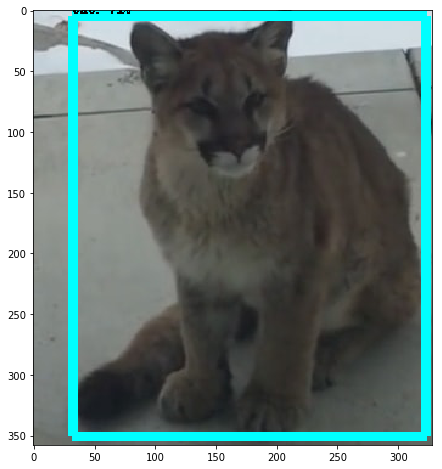

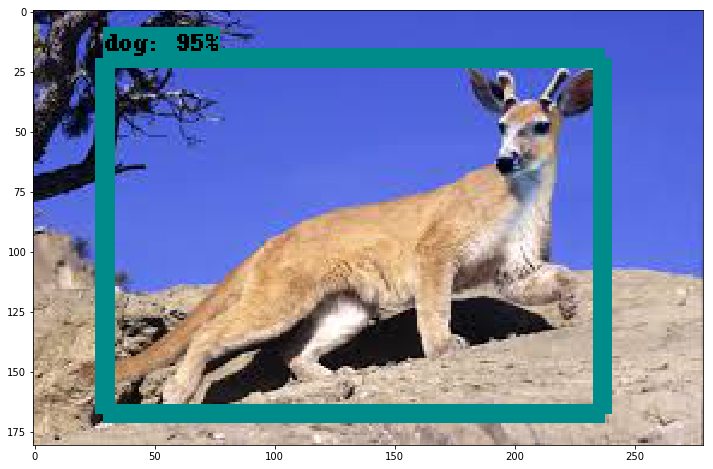

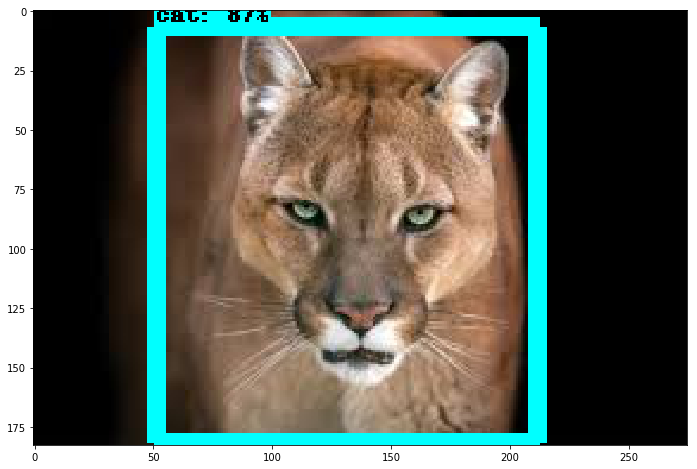

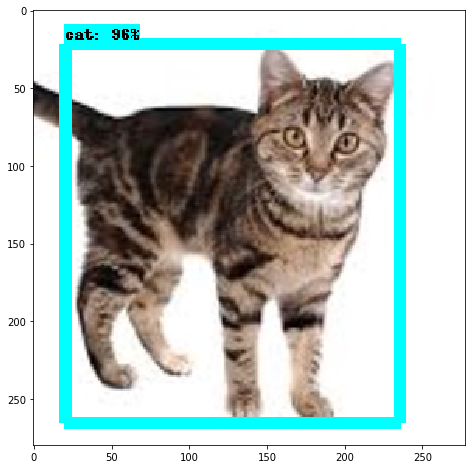

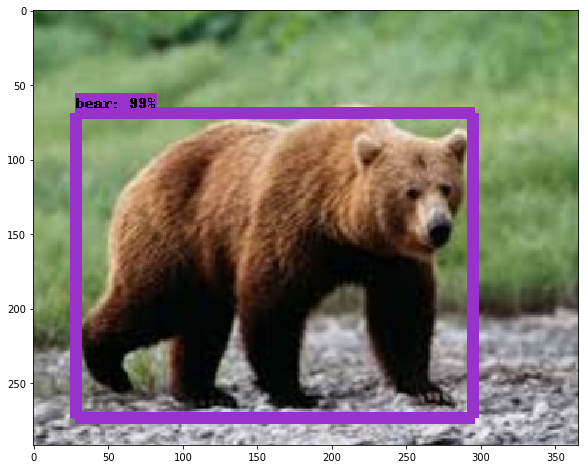

In [14]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)
      

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            print "hi"
            image_process = detect_objects(image, sess, detection_graph)
            return image_process

In [17]:
white_output = 'video1_out.mp4'
clip1 = VideoFileClip("video1.mp4").subclip(1,2)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output, audio=False)

IOError: MoviePy error: the file video1.mp4 could not be found !
Please check that you entered the correct path.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
white_output1 = 'cars_out.mp4'
clip1 = VideoFileClip("cars.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output1, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output1))

In [ ]:
white_output2 = 'fruits1_out.mp4'
clip2 = VideoFileClip("fruits1.mp4").subclip(0,1)
white_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output2, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output2))

In [ ]:
white_output3 = 'dog_out.mp4'
clip3 = VideoFileClip("dog.mp4").subclip(12,14)
white_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output3, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output3))

In [ ]:
# Merge videos
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip1 = VideoFileClip("cars_out.mp4")
clip2 = VideoFileClip("fruits1_out.mp4")
clip3 = VideoFileClip("dog_out.mp4")
final_clip = concatenate_videoclips([clip1,clip2,clip3], method="compose")
final_clip.write_videofile("my_concatenation.mp4",bitrate="5000k")

In [ ]:
from moviepy.editor import *
clip = VideoFileClip("my_concatenation.mp4")
clip.write_gif("final.gif")